# Assessing MLE convergence

In [1]:
from gcdyn import models, poisson, utils, mutators
import jax.numpy as np
from jax.config import config
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

Let's try fitting models with different initial values for the parameters

In [4]:
seed = 10

# (Deliberately avoiding rate parameters == constant 1, because a lot of bugs hide in this scenario)
true_parameters = {
    "birth_response": poisson.SigmoidResponse(1.0, 5.0, 2.0, 0.5),
    "death_response": poisson.ConstantResponse(1.3),
    "mutation_response": poisson.ConstantResponse(1.2),
    "mutator": mutators.DiscreteMutator(
        state_space=(1, 3, 5, 7, 9),
        transition_matrix=np.array(
            [
                [3, 2, 2, 1, 1],
                [2, 3, 2, 1, 1],
                [1, 2, 3, 2, 1],
                [1, 1, 2, 3, 2],
                [1, 1, 2, 2, 3],
            ]
        )
        / 9,
    ),
    "extant_sampling_probability": 1,
}

PRESENT_TIME = 4

trees = utils.sample_trees(n=1, t=PRESENT_TIME, init_x=1, **true_parameters, seed=seed)

for tree in trees:
    tree._pruned = True

Notice: obtained error 'number of survivors 0 is less than min_survivors=1' 1 times.
Success: average of 164.0 nodes per tree, over 1 trees.


In [5]:
magnitudes = []
log_liks = []

truth = true_parameters["birth_response"]._flatten()[2]
search_space = itertools.product(
    np.arange(0.0, 5.0), np.arange(0.0, 5.0), np.arange(-5.0, 5.0), np.arange(0.0, 5.0)
)

model = models.BirthDeathModel(
    log_likelihood=models.stadler_appx_log_likelihood,
    trees=trees,
    optimized_parameters={
        "birth_response": None,
    },
    fixed_parameters={
        "death_response": true_parameters["death_response"],
        "mutation_response": true_parameters["mutation_response"],
        "mutator": true_parameters["mutator"],
        "extant_sampling_probability": true_parameters["extant_sampling_probability"],
        "extinct_sampling_probability": 1,
        "present_time": PRESENT_TIME,
    },
)

for xsc, xsh, ysc, ysh in tqdm(list(search_space)):
    model.parameters["birth_response"] = poisson.SigmoidResponse(xsc, xsh, ysc, ysh)
    model.fit()

    result = model.parameters["birth_response"]._flatten()[2]
    magnitudes.append(sum((np.array(truth) - np.array(result)) ** 2).item())
    log_liks.append(model.log_likelihood().item())

100%|██████████| 1250/1250 [06:50<00:00,  3.05it/s]


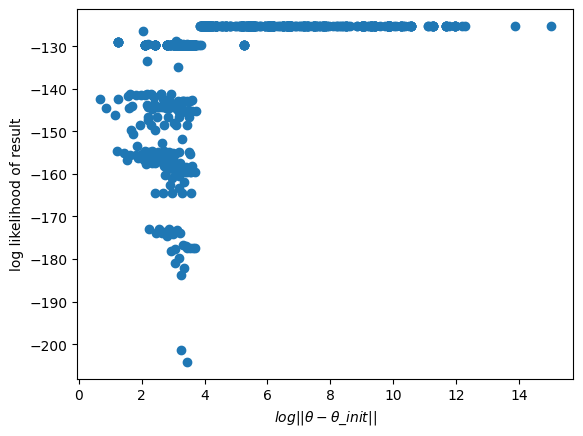

In [13]:
plt.scatter(np.log(np.vstack(magnitudes)), np.vstack(log_liks))
plt.xlabel(r"$log ||\theta - \theta\_init||$")
plt.ylabel("log likelihood of result")
plt.show()